In [1]:
import numpy as np
from numpy import ones
from numpy_sugar import ddot
# import os
# import sys
import pandas as pd
from pandas_plink import read_plink1_bin
from numpy.linalg import cholesky
from numpy_sugar.linalg import economic_svd
import xarray as xr
from struct_lmm2 import StructLMM2
from limix.qc import quantile_gaussianize
import matplotlib.pyplot as plt

In [2]:
import struct_lmm2 # check that it refers to code in repo
struct_lmm2

<module 'struct_lmm2' from '/hps/nobackup/stegle/users/acuomo/git_repos/struct-lmm2/struct_lmm2/__init__.py'>

In [3]:
chrom = 2

In [4]:
## this file will map cells to donors, it will also only including donors we have single cell data (a subset of all of HipSci donors)
sample_mapping_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/sample_mapping_file.tsv"
sample_mapping = pd.read_csv(sample_mapping_file, sep='\t', dtype={"genotype_individual_id": str, "phenotype_sample_id": str})

In [5]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 126


In [6]:
## read in genotype file
plink_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [05:55<00:00, 118.48s/it]


In [7]:
G.shape

(1610, 10464962)

In [8]:
## read in GRM kinship matrix
kinship_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink-F/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index)

In [9]:
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 125


In [10]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [11]:
## and decompose such as K = L @ L.T
L_kinship = cholesky(K.values)
L_kinship = xr.DataArray(L_kinship, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(L_kinship.sample.values == K.sample_0.values)

In [12]:
np.allclose(K.values, L_kinship.values @ L_kinship.values.T)

True

In [13]:
del K
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 36044
Sample mapping number of rows AFTER intersection: 35751


In [14]:
# expand from donors to cells
L_expanded = L_kinship.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [153]:
# environments
# cells by MOFA factors (10)
E_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/mofa_logcounts_model_factors.csv"
E = pd.read_csv(E_file, index_col = 0)
E = xr.DataArray(E.values, dims=["cell", "pc"], coords={"cell": E.index.values, "pc": E.columns.values})
E = E.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(E.cell.values == sample_mapping["phenotype_sample_id"].values)

In [16]:
E.head()

<xarray.DataArray (cell: 5, pc: 5)>
array([[-0.54978801,  1.11583786,  0.09235695,  1.40225012,  0.64556476],
       [ 0.26934134,  2.19734218,  0.70375016,  0.93139237, -0.33624749],
       [-0.02561868,  1.81561723, -0.07399272,  0.29092987,  0.06909543],
       [-0.69904249,  1.17026377,  0.17953677,  0.50106947,  1.54701071],
       [-0.22270389,  1.5511408 , -0.15298686,  0.26316878,  0.7975027 ]])
Coordinates:
  * cell     (cell) object '21843_1#10' '21843_1#100' ... '21843_1#103'
  * pc       (pc) object 'MOFA1' 'MOFA2' 'MOFA3' 'MOFA4' 'MOFA5'

In [17]:
G_sel = G.where(G.chrom == str(chrom), drop=True)
G_exp = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == G_exp.sample.values)

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2542 times more chunks
  return self.array[key]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [18]:
# from 10,464,962 down to 903,871 variants
# same 1,610 individuals
G_sel.shape

(1610, 903871)

In [19]:
# expanded out to all 35,751 cells
G_exp.shape

(35751, 903871)

In [154]:
# sub-select E prior to decomposition of background term K*EEt
n_factors = 1
E = E.values[:,0:n_factors]

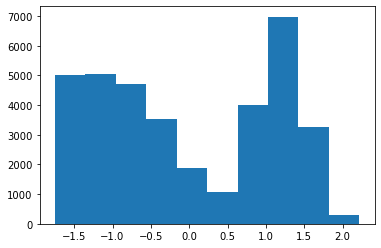

In [155]:
plt.hist(E[:,0])
plt.show()

In [21]:
# get decomposition of K*EEt 
# i.e. get Li's such that K*EEt = L1L1t + L2L2t + ..
[U, S, _] = economic_svd(E)
del _

In [22]:
us = U * S
Ls = [ddot(us[:,i], L_expanded) for i in range(us.shape[1])]
del us

In [23]:
# Phenotype (single-cell gene expression)
# phenotype_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/exprs_alldays_allgenes.tsv"
# phenotype = pd.read_csv(phenotype_file, sep = "\t")

In [24]:
phenotype_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/exprs_alldays_allgenes.tsv.pkl"
phenotype = pd.read_pickle(phenotype_file)

In [25]:
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))

Phenotype shape BEFORE selection: (11231, 36044)


In [26]:
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape AFTER selection: (11231, 35751)


In [27]:
# Filter on specific gene-SNP pairs
# eQTL from endodiff (ips+mesendo+defendo)
endo_eqtl_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/eqtl_allstages.tsv"
endo_eqtl = pd.read_csv(endo_eqtl_file, sep="\t", index_col = False)
endo_eqtl["chrom"] = [int(i[:i.find("_")]) for i in endo_eqtl["snp_id"]]
genes = endo_eqtl[endo_eqtl['chrom']==int(chrom)]['feature'].unique()

In [28]:
len(genes)

230

In [29]:
# set up model
# starting with (fixed effect) covariates
n_samples = phenotype.shape[1]
M = ones((n_samples, 1))

In [30]:
# column gaussianise environment(s)
E = quantile_gaussianize(E)

In [140]:
i = 9
trait_name = genes[i]
trait_name

'ENSG00000213160_KLHL23'

In [141]:
y = phenotype.sel(trait=trait_name)

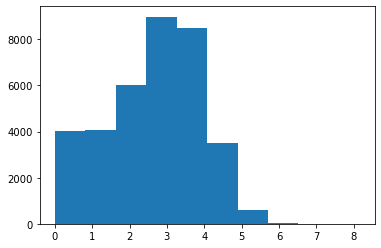

In [142]:
plt.hist(y)
plt.show()

In [143]:
y = quantile_gaussianize(y)

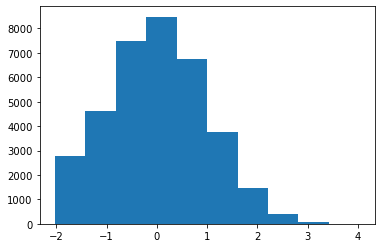

In [144]:
plt.hist(y)
plt.show()

In [145]:
# select SNPs
leads = endo_eqtl[endo_eqtl['feature']==trait_name]['snp_id'].unique()
leads

array(['2_170575157_G_A', '2_170617443_T_C', '2_170630637_A_G'],
      dtype=object)

In [146]:
G_tmp = G_exp[:,G_exp['snp'].isin(leads)]
G_tmp.shape

(35751, 3)

In [147]:
print("Running for gene {}".format(trait_name))
# null model
slmm2 = StructLMM2(y.values, M, E, Ls)

Running for gene ENSG00000213160_KLHL23


In [148]:
ok = np.var(G_tmp.values, axis=0) > 0.0
pvals = np.full(G_tmp.shape[1], np.nan)

In [149]:
# interaction test
pvals[ok] = slmm2.scan_interaction(G_tmp[:, ok])[0]

100%|██████████| 3/3 [00:46<00:00, 15.42s/it]


In [150]:
pv = pd.DataFrame({"chrom":G_tmp.chrom.values,
    "pv":pvals,
    "variant":G_tmp.snp.values})

In [151]:
# ENSG00000213160_KLHL23
pv.head()

,chrom,pv,variant
0,2,0.656151,2_170575157_G_A
1,2,0.142658,2_170617443_T_C
2,2,0.223427,2_170630637_A_G


In [139]:
# ENSG00000240344_PPIL3
pv.head()

,chrom,pv,variant
0,2,0.274602,2_201742345_C_T
1,2,0.363557,2_201754063_T_C
2,2,0.926715,2_201774355_T_C


In [127]:
# ENSG00000136717_BIN1
pv.head()

,chrom,pv,variant
0,2,0.484393,2_127846505_T_C
1,2,0.511302,2_127859418_T_C
2,2,0.511302,2_127863029_C_T


In [115]:
# ENSG00000196208_GREB1
pv.head()

,chrom,pv,variant
0,2,0.089768,2_11720282_A_G
1,2,0.049319,2_11736305_G_A


In [103]:
# ENSG00000035141_FAM136A
pv.head()

,chrom,pv,variant
0,2,0.000008,2_70426325_C_T
1,2,0.000958,2_70502930_A_G
2,2,0.003274,2_70541419_A_G


In [91]:
# ENSG00000237651_C2orf74
pv.head()

,chrom,pv,variant
0,2,0.012918,2_61372507_A_G
1,2,0.099994,2_61381018_C_T
2,2,0.013306,2_61400816_G_A


In [79]:
# ENSG00000138032_PPM1B
pv.head()

,chrom,pv,variant
0,2,0.027048,2_44396235_T_G


In [67]:
# ENSG00000144120_TMEM177
pv.head()

,chrom,pv,variant
0,2,0.000002,2_120438523_A_G


In [42]:
# ENSG00000183891_TTC32
pv.head()

,chrom,pv,variant
0,2,0.191488,2_20082172_T_C
1,2,0.069062,2_20090677_G_A


In [54]:
# ENSG00000229150_CRYGEP
pv.head()

,chrom,pv,variant
0,2,8.614741e-18,2_208977362_C_A
1,2,2.129682e-15,2_208977797_G_T


In [55]:
len(Ls)

1

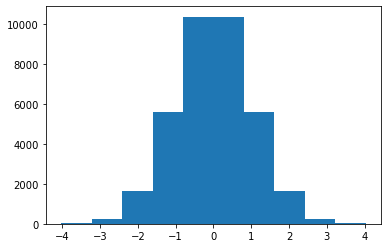

In [152]:
plt.hist(E[:,0])
plt.show()